# Data prep

## Import packages

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


## Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009


## Feature engineering 

In [4]:
sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,STAR,-0.000009,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,STAR,-0.000055,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,GALAXY,0.123111,1.297604,-0.590023,0.140338
3,183.870529,0.049911,STAR,-0.000111,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,STAR,0.000590,-0.849271,1.287505,-0.397689


## Split into train/test sets

In [5]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scale the data

In [6]:
robust_scaler = RobustScaler()
std_scaler = StandardScaler()
maxabs_scaler = MaxAbsScaler()

X_train_std_scaled = std_scaler.fit_transform(X_train.astype(np.float64))
X_test_std_scaled = std_scaler.fit_transform(X_test.astype(np.float64))

X_train_rob_scaled = robust_scaler.fit_transform(X_train.astype(np.float64))
X_test_rob_scaled = robust_scaler.fit_transform(X_test.astype(np.float64))

X_train_maxabs_scaled = maxabs_scaler.fit_transform(X_train.astype(np.float64))
X_test_maxabs_scaled = maxabs_scaler.fit_transform(X_test.astype(np.float64))

data_sets = []

std_scaled_set = DataSet("Standard Scaled", X_train_std_scaled, y_train, X_test_std_scaled, y_test)
robust_scaled_set = DataSet("Robust Scaled", X_train_rob_scaled, y_train, X_test_rob_scaled, y_test)
max_abs_set = DataSet("MaxABS Scaled", X_train_maxabs_scaled, y_train, X_test_maxabs_scaled, y_test)

data_sets.append(std_scaled_set)
data_sets.append(robust_scaled_set)
data_sets.append(max_abs_set)

# Classification

## Prepare result sets

In [7]:
result_sets = []

# Classfiers
knn_clf = KNeighborsClassifier()
svm_clf = SVC(gamma="auto", random_state=42)
lsvm_clf = LinearSVC(C=10, loss="hinge", random_state=42)
nusvm_clf = NuSVC(nu=0.05, gamma=0.1)
rbf_svm_clf = SVC(kernel="rbf", gamma=0.1, C=1000)
poly_svm_clf = SVC(kernel="poly", gamma="scale", degree=3, coef0=100, C=5)
tree_clf = DecisionTreeClassifier(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
log_clf = LogisticRegression(
    solver="liblinear", random_state=42, multi_class='auto')
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,
                                    max_features=2, max_depth=4, random_state=42)
# Xgboost parameters
xgb_params = {'learning_rate': 0.05,
              'max_depth': 4,
              'subsample': 0.9,
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1,
              'n_estimators': 100,
              'gamma': 1,
              'min_child_weight': 4,
              # ENABLE GPU COMPUTING BY UNCOMMENTING BELOW
              # 'gpu_id': 0,
              # 'tree_method': 'gpu_hist'
              }
xgb_clf = XGBClassifier(**xgb_params, seed=42)
bag_df_clf = BaggingClassifier(
    DecisionTreeClassifier(
        splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
sgd_clf = SGDClassifier(max_iter=500, tol=-np.infty, random_state=42)
mlp_clf = MLPClassifier(random_state=42, max_iter=2000)
xtree_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
pa_clf = PassiveAggressiveClassifier(max_iter=5000, random_state=0, tol=1e-3)
r_clf = RidgeClassifier()
nb_clf = GaussianNB()
mnb_clf = MultinomialNB()
lda_clf = LinearDiscriminantAnalysis()
qda_clf = QuadraticDiscriminantAnalysis()
v_clf = VotingClassifier(estimators=[
    ("SVC", svm_clf),
    ("NuSVC", nusvm_clf),
    ("RbfSVC", rbf_svm_clf),
    ("PolySVC", poly_svm_clf),
    ("Tree", tree_clf),
    ("RF", rnd_clf),
    ("XGB", xgb_clf),
    ("Bagging", bag_df_clf),
    ("MLP", mlp_clf),
    ("XTrees", xtree_clf),
    ("NaiveBayes", nb_clf),
    ("QDA", qda_clf),
], voting="hard", n_jobs=-1)

# CLF names
clf_names = ["KNN",
             "SVC",
             "LinearSVM",
             "NuSVC",
             "RbfKernelSVM",
             "PolyKernelSVM",
             "DecisionTreeClassifier",
             "RandomForestClassifier",
             "LogisticRegression",
             "GradientBoostingClassifier",
             "XGBClassifier",
             "BaggingClassifier",
             "AdaBoostClassifier",
             "SGDClassifier",
             "MLPClassifier",
             "ExtraTreesClassifier",
             "PassiveAggressiveClassifier",
             "RidgeClassifier",
             "GaussianNB",
             "MultinomialNB",
             "LinearDiscriminantAnalysis",
             "QuadraticDiscriminantAnalysis",
             "VotingClassifier"]

clfs = [knn_clf,
        svm_clf,
        lsvm_clf,
        nusvm_clf,
        rbf_svm_clf,
        poly_svm_clf,
        tree_clf,
        rnd_clf,
        log_clf,
        gb_clf,
        xgb_clf,
        bag_df_clf,
        ada_clf,
        sgd_clf,
        mlp_clf,
        xtree_clf,
        pa_clf,
        r_clf,
        nb_clf,
        mnb_clf,
        lda_clf,
        qda_clf,
        v_clf]

## Run

Data Set Type:  Standard Scaled
[0.90206529 0.88607595 0.908      0.8945964  0.89793195]
Accuracy: 0.898 (+/- 0.015)
KNN :
 [[1060    2  184]
 [  12  218   12]
 [ 155    4  853]]


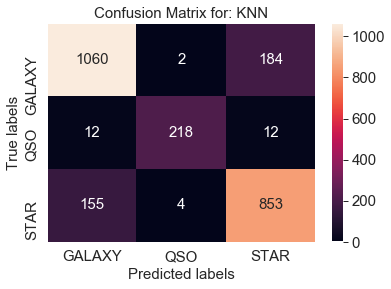

              precision    recall  f1-score   support

      GALAXY       0.86      0.85      0.86      1246
         QSO       0.97      0.90      0.94       242
        STAR       0.81      0.84      0.83      1012

   micro avg       0.85      0.85      0.85      2500
   macro avg       0.88      0.86      0.87      2500
weighted avg       0.85      0.85      0.85      2500



[0.9586942  0.95003331 0.966      0.9646431  0.96197465]
Accuracy: 0.960 (+/- 0.011)
SVC :
 [[1106    3  137]
 [  16  224    2]
 [  24    1  987]]


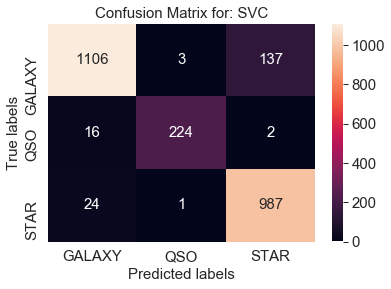

              precision    recall  f1-score   support

      GALAXY       0.97      0.89      0.92      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.88      0.98      0.92      1012

   micro avg       0.93      0.93      0.93      2500
   macro avg       0.94      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



[0.96802132 0.9673551  0.97866667 0.97598399 0.96997999]
Accuracy: 0.972 (+/- 0.009)
LinearSVM :
 [[1193    3   50]
 [  27  215    0]
 [  12    1  999]]


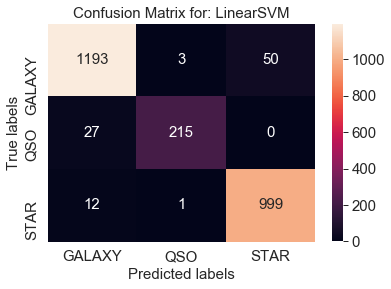

              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.96      1246
         QSO       0.98      0.89      0.93       242
        STAR       0.95      0.99      0.97      1012

   micro avg       0.96      0.96      0.96      2500
   macro avg       0.97      0.94      0.96      2500
weighted avg       0.96      0.96      0.96      2500



[0.98001332 0.97534977 0.98733333 0.98732488 0.98732488]
Accuracy: 0.983 (+/- 0.010)
NuSVC :
 [[1219    3   24]
 [  16  225    1]
 [   6    1 1005]]


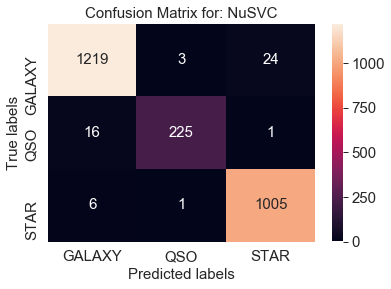

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.98      0.93      0.96       242
        STAR       0.98      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.98401066 0.98067955 0.98933333 0.98532355 0.98599066]
Accuracy: 0.985 (+/- 0.006)
RbfKernelSVM :
 [[1219    4   23]
 [  17  224    1]
 [  11    2  999]]


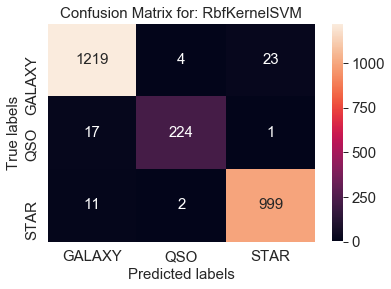

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.97      0.93      0.95       242
        STAR       0.98      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.96      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.98934044 0.98867422 0.99       0.99199466 0.98799199]
Accuracy: 0.990 (+/- 0.003)
PolyKernelSVM :
 [[1229    7   10]
 [  17  225    0]
 [   6    2 1004]]


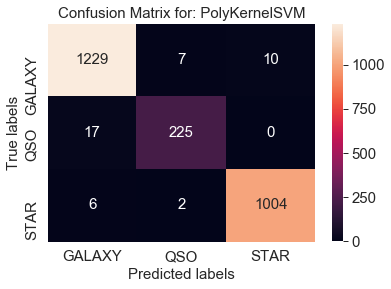

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98      1246
         QSO       0.96      0.93      0.95       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.98600933 0.98600933 0.98866667 0.98198799 0.98732488]
Accuracy: 0.986 (+/- 0.004)
DecisionTreeClassifier :
 [[1220   19    7]
 [  16  226    0]
 [   4    0 1008]]


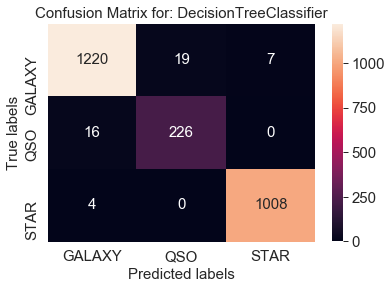

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.92      0.93      0.93       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.9853431  0.9853431  0.99133333 0.98799199 0.98999333]
Accuracy: 0.988 (+/- 0.005)
RandomForestClassifier :
 [[1232    4   10]
 [  14  228    0]
 [   1    0 1011]]


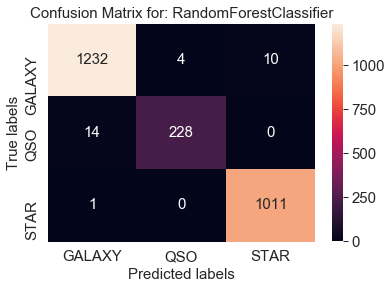

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.94470353 0.94603598 0.96066667 0.95263509 0.94796531]
Accuracy: 0.950 (+/- 0.012)
LogisticRegression :
 [[1128    3  115]
 [  25  217    0]
 [  34    0  978]]


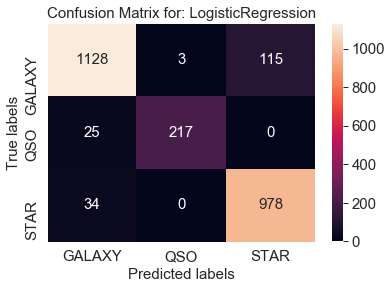

              precision    recall  f1-score   support

      GALAXY       0.95      0.91      0.93      1246
         QSO       0.99      0.90      0.94       242
        STAR       0.89      0.97      0.93      1012

   micro avg       0.93      0.93      0.93      2500
   macro avg       0.94      0.92      0.93      2500
weighted avg       0.93      0.93      0.93      2500



[0.98667555 0.98467688 0.99133333 0.98865911 0.99066044]
Accuracy: 0.988 (+/- 0.005)
GradientBoostingClassifier :
 [[1233    5    8]
 [  12  230    0]
 [   1    0 1011]]


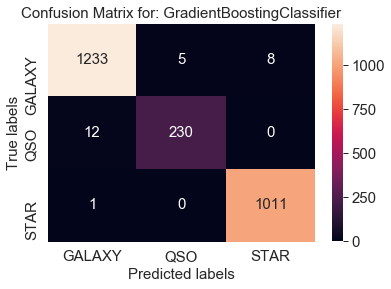

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98867422 0.9853431  0.99066667 0.98865911 0.99199466]
Accuracy: 0.989 (+/- 0.005)
XGBClassifier :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]


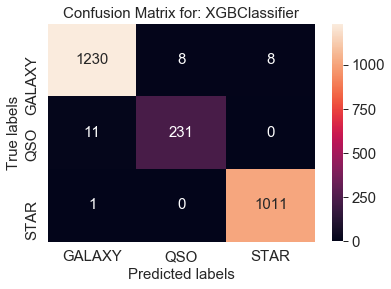

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98201199 0.9793471  0.986      0.98599066 0.98799199]
Accuracy: 0.984 (+/- 0.006)
BaggingClassifier :
 [[1232    4   10]
 [  13  229    0]
 [   0    0 1012]]


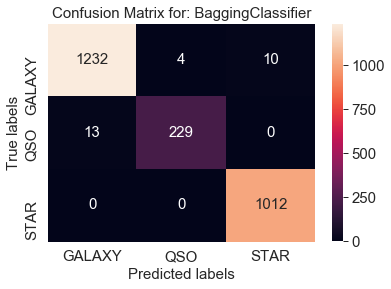

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.67954697 0.93404397 0.66266667 0.82054703 0.74116077]
Accuracy: 0.768 (+/- 0.200)
AdaBoostClassifier :
 [[1223   16    7]
 [ 125  117    0]
 [ 151    0  861]]


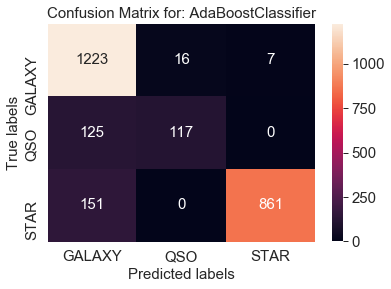

              precision    recall  f1-score   support

      GALAXY       0.82      0.98      0.89      1246
         QSO       0.88      0.48      0.62       242
        STAR       0.99      0.85      0.92      1012

   micro avg       0.88      0.88      0.88      2500
   macro avg       0.90      0.77      0.81      2500
weighted avg       0.89      0.88      0.88      2500



[0.96602265 0.96002665 0.972      0.97398266 0.96664443]
Accuracy: 0.968 (+/- 0.010)
SGDClassifier :
 [[1185    3   58]
 [  30  212    0]
 [  13    1  998]]


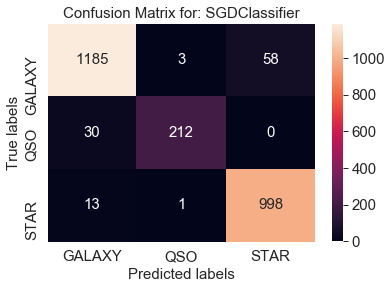

              precision    recall  f1-score   support

      GALAXY       0.96      0.95      0.96      1246
         QSO       0.98      0.88      0.93       242
        STAR       0.95      0.99      0.97      1012

   micro avg       0.96      0.96      0.96      2500
   macro avg       0.96      0.94      0.95      2500
weighted avg       0.96      0.96      0.96      2500



[0.98401066 0.98267821 0.99       0.98999333 0.97998666]
Accuracy: 0.985 (+/- 0.008)
MLPClassifier :
 [[1188    5   53]
 [  11  231    0]
 [  10    2 1000]]


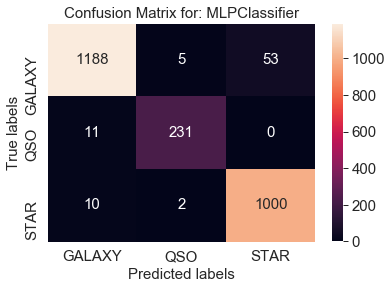

              precision    recall  f1-score   support

      GALAXY       0.98      0.95      0.97      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.95      0.99      0.97      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]


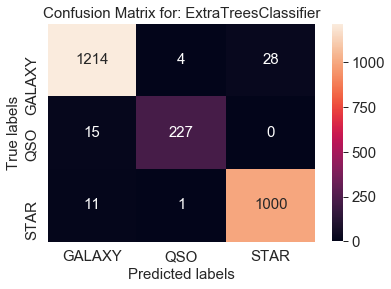

              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.96602265 0.93137908 0.97133333 0.94596398 0.9593062 ]
Accuracy: 0.955 (+/- 0.029)
PassiveAggressiveClassifier :
 [[1151   25   70]
 [  34  208    0]
 [ 104    2  906]]


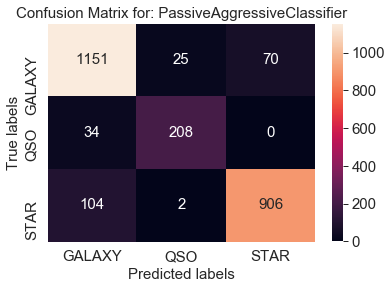

              precision    recall  f1-score   support

      GALAXY       0.89      0.92      0.91      1246
         QSO       0.89      0.86      0.87       242
        STAR       0.93      0.90      0.91      1012

   micro avg       0.91      0.91      0.91      2500
   macro avg       0.90      0.89      0.90      2500
weighted avg       0.91      0.91      0.91      2500



[0.92205197 0.90739507 0.93266667 0.9239493  0.91661107]
Accuracy: 0.921 (+/- 0.017)
RidgeClassifier :
 [[1113    0  133]
 [  36  188   18]
 [  84    1  927]]


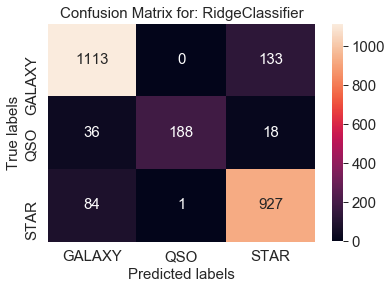

              precision    recall  f1-score   support

      GALAXY       0.90      0.89      0.90      1246
         QSO       0.99      0.78      0.87       242
        STAR       0.86      0.92      0.89      1012

   micro avg       0.89      0.89      0.89      2500
   macro avg       0.92      0.86      0.89      2500
weighted avg       0.89      0.89      0.89      2500



[0.98001332 0.9733511  0.98066667 0.97464977 0.98465644]
Accuracy: 0.979 (+/- 0.008)
GaussianNB :
 [[1218   21    7]
 [  11  231    0]
 [   3    7 1002]]


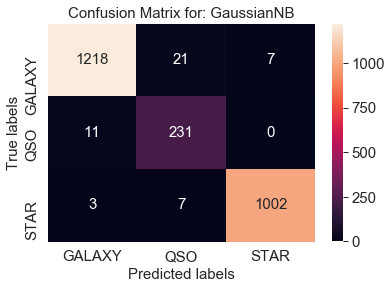

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.89      0.95      0.92       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.96      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



Something bad had happened... Could not proceed for the:  MultinomialNB 

[0.93537642 0.91672219 0.946      0.9299533  0.92328219]
Accuracy: 0.930 (+/- 0.020)
LinearDiscriminantAnalysis :
 [[1131    0  115]
 [  45  185   12]
 [  74    2  936]]


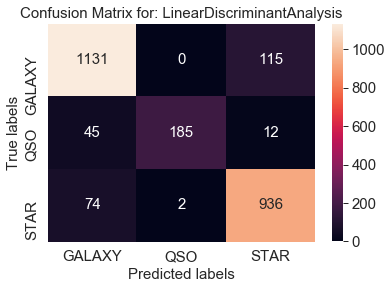

              precision    recall  f1-score   support

      GALAXY       0.90      0.91      0.91      1246
         QSO       0.99      0.76      0.86       242
        STAR       0.88      0.92      0.90      1012

   micro avg       0.90      0.90      0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.90      0.90      0.90      2500



[0.9793471  0.98134577 0.98666667 0.98865911 0.98732488]
Accuracy: 0.985 (+/- 0.007)
QuadraticDiscriminantAnalysis :
 [[1225   15    6]
 [   5  237    0]
 [   9    2 1001]]


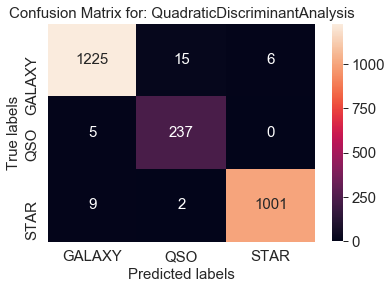

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.93      0.98      0.96       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.97      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98600933 0.98401066 0.99133333 0.98999333 0.99066044]
Accuracy: 0.988 (+/- 0.006)
VotingClassifier :
 [[1232    4   10]
 [  13  229    0]
 [   1    0 1011]]


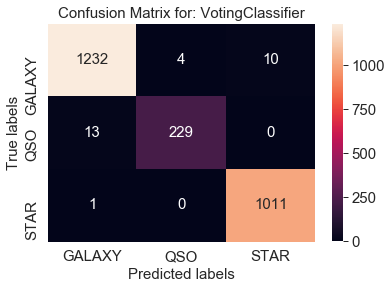

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
PolyKernelSVM 0.9896002629334502
XGBClassifier 0.9890675515263192
VotingClassifier 0.9884014178376672
GradientBoostingClassifier 0.9884010622819537
RandomForestClassifier 0.9880009732152473
DecisionTreeClassifier 0.9859996392294693
MLPClassifier 0.9853337721483431
RbfKernelSVM 0.9850675498670591
QuadraticDiscriminantAnalysis 0.9846687054823876
BaggingClassifier 0.9842683498081554
NuSVC 0.9834692382233652
ExtraTreesClassifier 0.9809344818375475
GaussianNB 0.9786674589040558
LinearSVM 0.9720014116747014
SGDClassifier 0.967735277037901
SVC 0.9602690520306899
PassiveAggressiveClassifier 0.9548010491263923


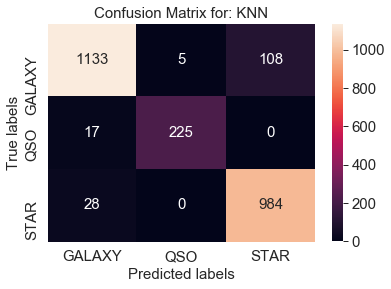

              precision    recall  f1-score   support

      GALAXY       0.96      0.91      0.93      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.90      0.97      0.94      1012

   micro avg       0.94      0.94      0.94      2500
   macro avg       0.95      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



[0.98067955 0.9733511  0.98466667 0.98599066 0.98332221]
Accuracy: 0.982 (+/- 0.009)
SVC :
 [[1198    3   45]
 [  16  226    0]
 [   0    2 1010]]


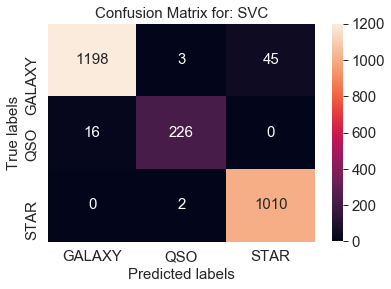

              precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.97      1246
         QSO       0.98      0.93      0.96       242
        STAR       0.96      1.00      0.98      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.96      0.97      2500
weighted avg       0.97      0.97      0.97      2500



[0.96868754 0.96868754 0.98333333 0.97731821 0.97198132]
Accuracy: 0.974 (+/- 0.011)
LinearSVM :
 [[1215    7   24]
 [  28  214    0]
 [  12    1  999]]


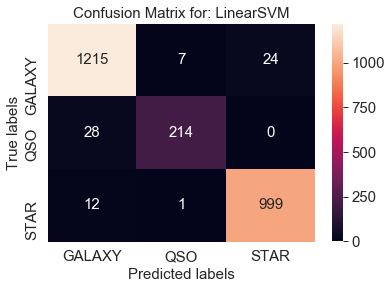

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97      1246
         QSO       0.96      0.88      0.92       242
        STAR       0.98      0.99      0.98      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.95      0.96      2500
weighted avg       0.97      0.97      0.97      2500



[0.98334444 0.97534977 0.986      0.98932622 0.98665777]
Accuracy: 0.984 (+/- 0.010)
NuSVC :
 [[1222    2   22]
 [  16  226    0]
 [   0    2 1010]]


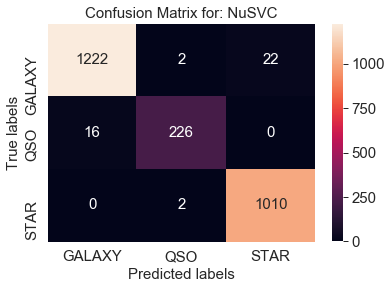

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.98      0.93      0.96       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.98      2500
weighted avg       0.98      0.98      0.98      2500



[0.98734177 0.98467688 0.98733333 0.98932622 0.98398933]
Accuracy: 0.987 (+/- 0.004)
RbfKernelSVM :
 [[1223    4   19]
 [  15  227    0]
 [   4    1 1007]]


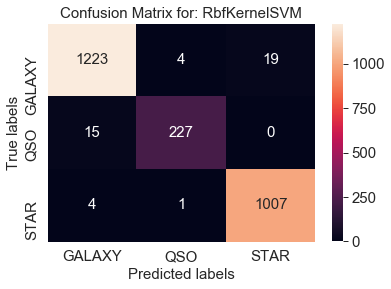

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.98      2500
weighted avg       0.98      0.98      0.98      2500



[0.99133911 0.99000666 0.994      0.99199466 0.99066044]
Accuracy: 0.992 (+/- 0.003)
PolyKernelSVM :
 [[1233    6    7]
 [  13  229    0]
 [   3    0 1009]]


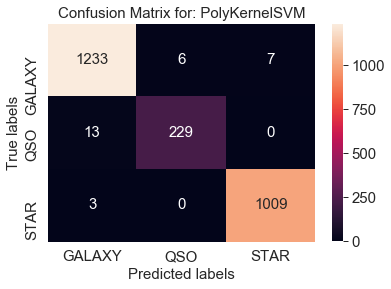

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98600933 0.98600933 0.98866667 0.98198799 0.98732488]
Accuracy: 0.986 (+/- 0.004)
DecisionTreeClassifier :
 [[1220   19    7]
 [  16  226    0]
 [   4    0 1008]]


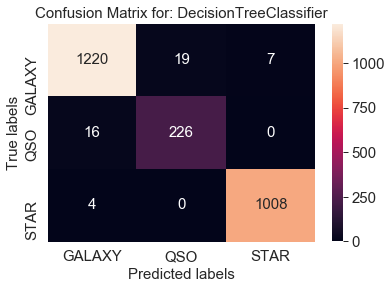

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.92      0.93      0.93       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.9853431  0.9853431  0.99133333 0.98799199 0.98999333]
Accuracy: 0.988 (+/- 0.005)
RandomForestClassifier :
 [[1232    4   10]
 [  14  228    0]
 [   1    0 1011]]


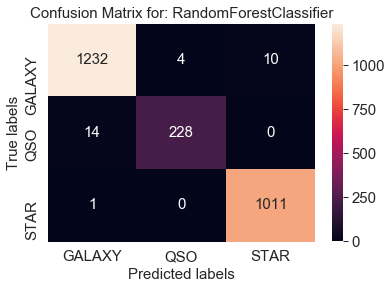

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.9673551  0.96535643 0.97533333 0.9766511  0.9706471 ]
Accuracy: 0.971 (+/- 0.009)
LogisticRegression :
 [[1171    4   71]
 [  18  224    0]
 [  13    0  999]]


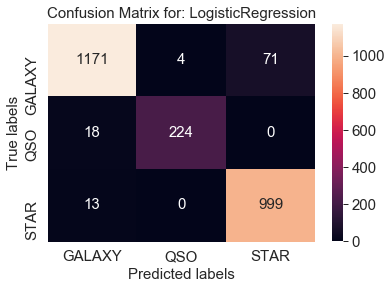

              precision    recall  f1-score   support

      GALAXY       0.97      0.94      0.96      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.93      0.99      0.96      1012

   micro avg       0.96      0.96      0.96      2500
   macro avg       0.96      0.95      0.96      2500
weighted avg       0.96      0.96      0.96      2500



[0.98667555 0.98467688 0.99133333 0.98865911 0.99066044]
Accuracy: 0.988 (+/- 0.005)
GradientBoostingClassifier :
 [[1233    5    8]
 [  12  230    0]
 [   1    0 1011]]


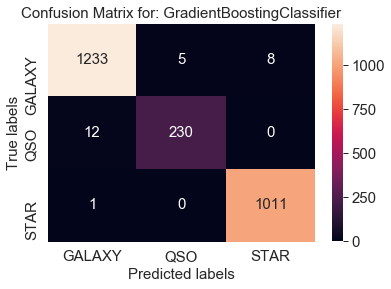

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98867422 0.9853431  0.99066667 0.98865911 0.99199466]
Accuracy: 0.989 (+/- 0.005)
XGBClassifier :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]


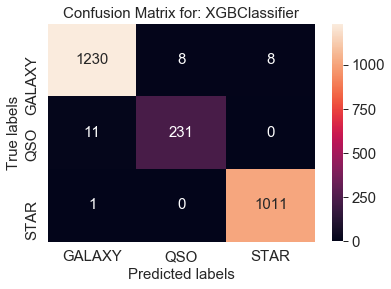

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98201199 0.9793471  0.986      0.98599066 0.98799199]
Accuracy: 0.984 (+/- 0.006)
BaggingClassifier :
 [[1232    4   10]
 [  13  229    0]
 [   0    0 1012]]


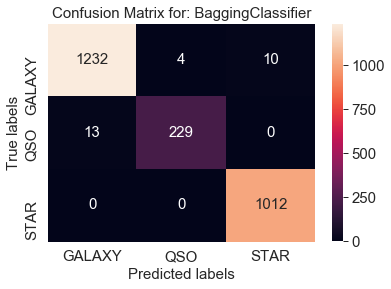

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.67954697 0.93404397 0.66266667 0.82054703 0.74116077]
Accuracy: 0.768 (+/- 0.200)
AdaBoostClassifier :
 [[1223   16    7]
 [ 125  117    0]
 [ 151    0  861]]


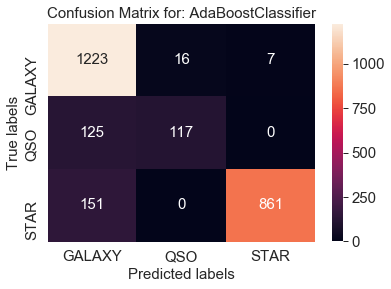

              precision    recall  f1-score   support

      GALAXY       0.82      0.98      0.89      1246
         QSO       0.88      0.48      0.62       242
        STAR       0.99      0.85      0.92      1012

   micro avg       0.88      0.88      0.88      2500
   macro avg       0.90      0.77      0.81      2500
weighted avg       0.89      0.88      0.88      2500



[0.96868754 0.96802132 0.97466667 0.9766511  0.97131421]
Accuracy: 0.972 (+/- 0.007)
SGDClassifier :
 [[1213    7   26]
 [  29  213    0]
 [  12    0 1000]]


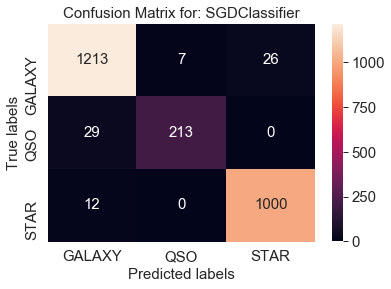

              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97      1246
         QSO       0.97      0.88      0.92       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.95      0.96      2500
weighted avg       0.97      0.97      0.97      2500



[0.98800799 0.98267821 0.99133333 0.99199466 0.98999333]
Accuracy: 0.989 (+/- 0.007)
MLPClassifier :
 [[1221    3   22]
 [  10  232    0]
 [   0    0 1012]]


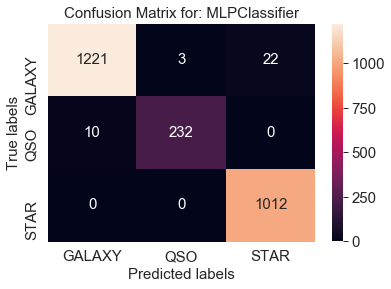

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.99      0.96      0.97       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]


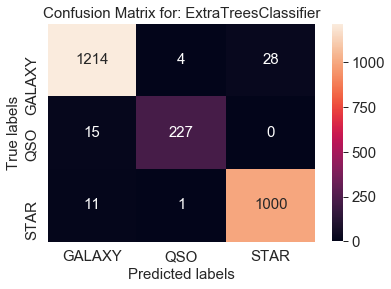

              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.97001999 0.96069287 0.91466667 0.97598399 0.97531688]
Accuracy: 0.959 (+/- 0.046)
PassiveAggressiveClassifier :
 [[1213   13   20]
 [  68  174    0]
 [  43    1  968]]


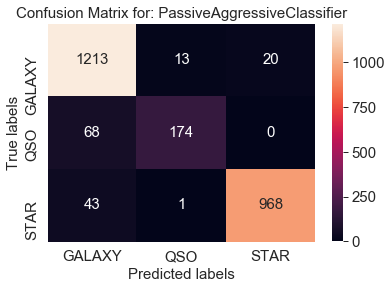

              precision    recall  f1-score   support

      GALAXY       0.92      0.97      0.94      1246
         QSO       0.93      0.72      0.81       242
        STAR       0.98      0.96      0.97      1012

   micro avg       0.94      0.94      0.94      2500
   macro avg       0.94      0.88      0.91      2500
weighted avg       0.94      0.94      0.94      2500



[0.92071952 0.90672885 0.93266667 0.92261508 0.91661107]
Accuracy: 0.920 (+/- 0.017)
RidgeClassifier :
 [[1112    0  134]
 [  36  188   18]
 [  87    1  924]]


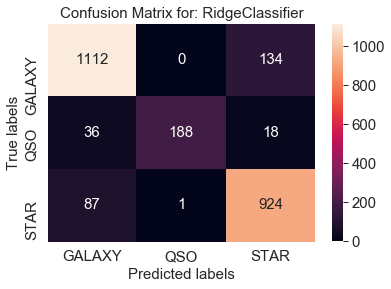

              precision    recall  f1-score   support

      GALAXY       0.90      0.89      0.90      1246
         QSO       0.99      0.78      0.87       242
        STAR       0.86      0.91      0.89      1012

   micro avg       0.89      0.89      0.89      2500
   macro avg       0.92      0.86      0.88      2500
weighted avg       0.89      0.89      0.89      2500



[0.98001332 0.9733511  0.98066667 0.97464977 0.98465644]
Accuracy: 0.979 (+/- 0.008)
GaussianNB :
 [[1218   21    7]
 [  11  231    0]
 [   3    7 1002]]


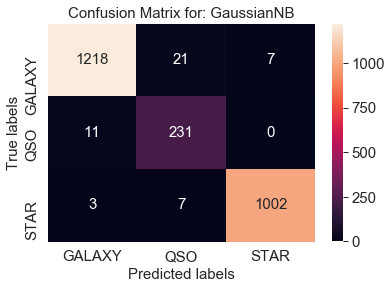

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.89      0.95      0.92       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.96      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



Something bad had happened... Could not proceed for the:  MultinomialNB 

[0.93537642 0.91672219 0.946      0.9299533  0.92328219]
Accuracy: 0.930 (+/- 0.020)
LinearDiscriminantAnalysis :
 [[1131    0  115]
 [  45  185   12]
 [  74    2  936]]


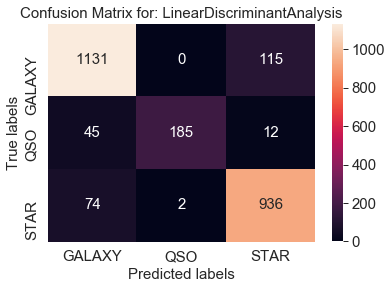

              precision    recall  f1-score   support

      GALAXY       0.90      0.91      0.91      1246
         QSO       0.99      0.76      0.86       242
        STAR       0.88      0.92      0.90      1012

   micro avg       0.90      0.90      0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.90      0.90      0.90      2500



[0.9793471  0.98134577 0.98666667 0.98865911 0.98732488]
Accuracy: 0.985 (+/- 0.007)
QuadraticDiscriminantAnalysis :
 [[1225   15    6]
 [   5  237    0]
 [   9    2 1001]]


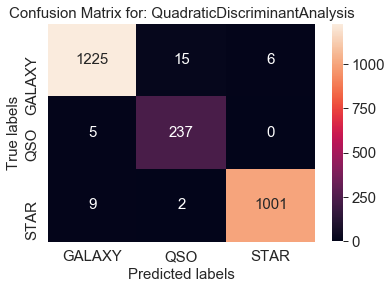

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.93      0.98      0.96       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.97      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.9853431  0.98401066 0.99066667 0.98932622 0.99132755]
Accuracy: 0.988 (+/- 0.006)
VotingClassifier :
 [[1234    4    8]
 [  13  229    0]
 [   1    0 1011]]


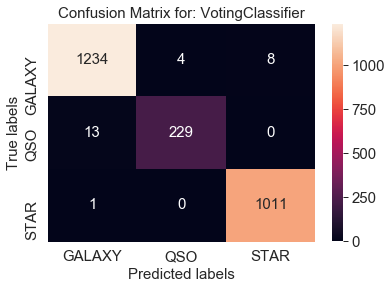

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
PolyKernelSVM 0.9916001745778553
XGBClassifier 0.9890675515263192
MLPClassifier 0.9888015069043735
GradientBoostingClassifier 0.9884010622819537
VotingClassifier 0.9881348400006695
RandomForestClassifier 0.9880009732152473
RbfKernelSVM 0.9865335062519287
DecisionTreeClassifier 0.9859996392294693
QuadraticDiscriminantAnalysis 0.9846687054823876
BaggingClassifier 0.9842683498081554
NuSVC 0.9841356386380615
SVC 0.9816020376305353
ExtraTreesClassifier 0.9809344818375475
GaussianNB 0.9786674589040558
LinearSVM 0.9740015899266327
SGDClassifier 0.971868167526593
LogisticRegression 0.9710686115564199
KNN 0.965

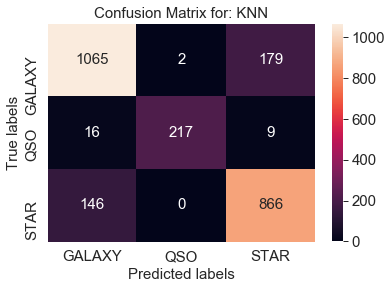

              precision    recall  f1-score   support

      GALAXY       0.87      0.85      0.86      1246
         QSO       0.99      0.90      0.94       242
        STAR       0.82      0.86      0.84      1012

   micro avg       0.86      0.86      0.86      2500
   macro avg       0.89      0.87      0.88      2500
weighted avg       0.86      0.86      0.86      2500



[0.76948701 0.75949367 0.77866667 0.77251501 0.77451634]
Accuracy: 0.771 (+/- 0.013)
SVC :
 [[1245    0    1]
 [  70  172    0]
 [1007    0    5]]


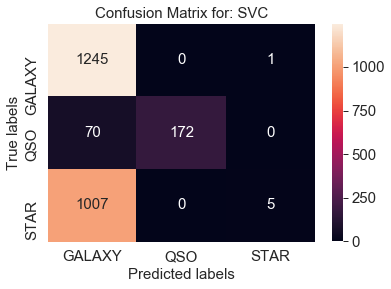

              precision    recall  f1-score   support

      GALAXY       0.54      1.00      0.70      1246
         QSO       1.00      0.71      0.83       242
        STAR       0.83      0.00      0.01      1012

   micro avg       0.57      0.57      0.57      2500
   macro avg       0.79      0.57      0.51      2500
weighted avg       0.70      0.57      0.43      2500



[0.91672219 0.92405063 0.928      0.92595063 0.92128085]
Accuracy: 0.923 (+/- 0.008)
LinearSVM :
 [[1054    2  190]
 [  16  226    0]
 [  62    0  950]]


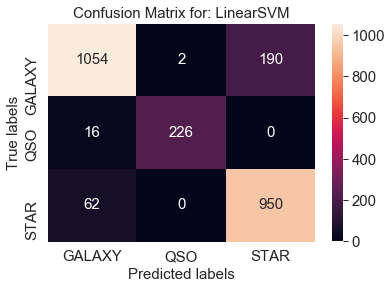

              precision    recall  f1-score   support

      GALAXY       0.93      0.85      0.89      1246
         QSO       0.99      0.93      0.96       242
        STAR       0.83      0.94      0.88      1012

   micro avg       0.89      0.89      0.89      2500
   macro avg       0.92      0.91      0.91      2500
weighted avg       0.90      0.89      0.89      2500



[0.94603598 0.94137242 0.95266667 0.96130754 0.96064043]
Accuracy: 0.952 (+/- 0.016)
NuSVC :
 [[1165    2   79]
 [  19  223    0]
 [  93    0  919]]


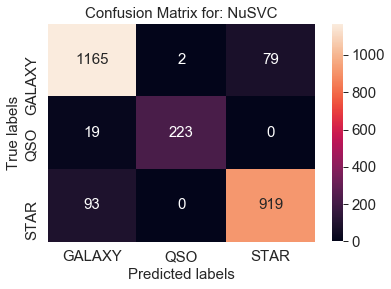

              precision    recall  f1-score   support

      GALAXY       0.91      0.93      0.92      1246
         QSO       0.99      0.92      0.96       242
        STAR       0.92      0.91      0.91      1012

   micro avg       0.92      0.92      0.92      2500
   macro avg       0.94      0.92      0.93      2500
weighted avg       0.92      0.92      0.92      2500



[0.97734843 0.97534977 0.98066667 0.98865911 0.98198799]
Accuracy: 0.981 (+/- 0.009)
RbfKernelSVM :
 [[1199    3   44]
 [   9  233    0]
 [   4    0 1008]]


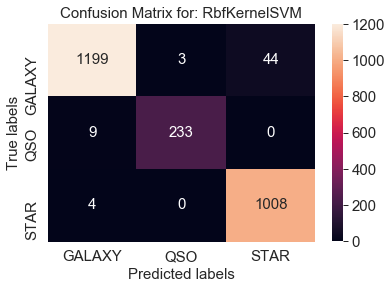

              precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.98      1246
         QSO       0.99      0.96      0.97       242
        STAR       0.96      1.00      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.98      2500
weighted avg       0.98      0.98      0.98      2500



[0.98734177 0.98667555 0.992      0.99266177 0.99066044]
Accuracy: 0.990 (+/- 0.005)
PolyKernelSVM :
 [[1224    4   18]
 [  11  231    0]
 [   2    0 1010]]


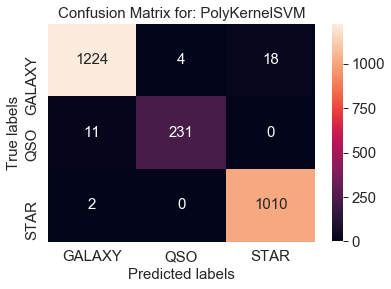

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.98      0.95      0.97       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98201199 0.98334444 0.98333333 0.98732488 0.98599066]
Accuracy: 0.984 (+/- 0.004)
DecisionTreeClassifier :
 [[1220   19    7]
 [  16  226    0]
 [   4    0 1008]]


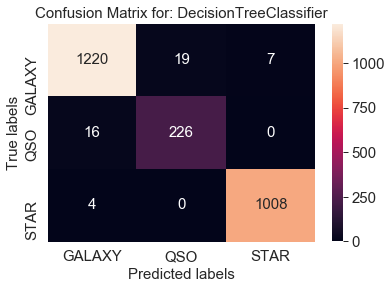

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.92      0.93      0.93       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.98600933 0.9853431  0.99133333 0.98799199 0.98999333]
Accuracy: 0.988 (+/- 0.005)
RandomForestClassifier :
 [[1232    4   10]
 [  14  228    0]
 [   1    0 1011]]


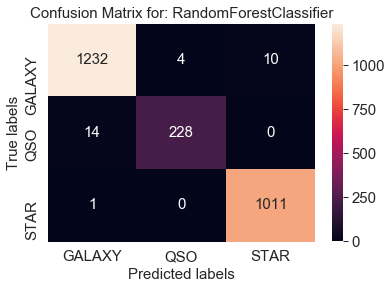

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.81012658 0.79013991 0.81333333 0.80386925 0.8072048 ]
Accuracy: 0.805 (+/- 0.016)
LogisticRegression :
 [[1097    1  148]
 [  19  189   34]
 [ 417    0  595]]


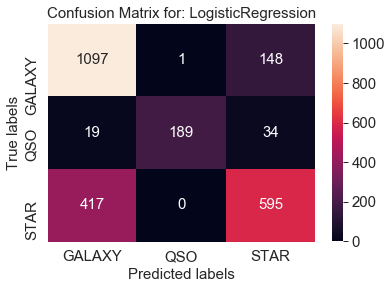

              precision    recall  f1-score   support

      GALAXY       0.72      0.88      0.79      1246
         QSO       0.99      0.78      0.88       242
        STAR       0.77      0.59      0.67      1012

   micro avg       0.75      0.75      0.75      2500
   macro avg       0.83      0.75      0.78      2500
weighted avg       0.76      0.75      0.75      2500



[0.98667555 0.98467688 0.99133333 0.98865911 0.99066044]
Accuracy: 0.988 (+/- 0.005)
GradientBoostingClassifier :
 [[1233    5    8]
 [  12  230    0]
 [   1    0 1011]]


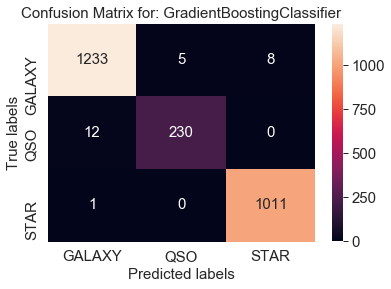

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98867422 0.9853431  0.99066667 0.98865911 0.99199466]
Accuracy: 0.989 (+/- 0.005)
XGBClassifier :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]


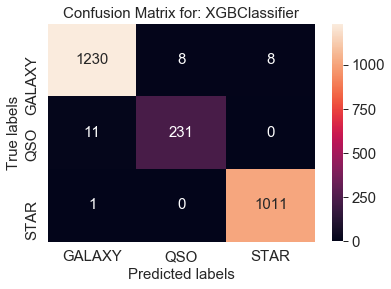

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98201199 0.9793471  0.986      0.98599066 0.98799199]
Accuracy: 0.984 (+/- 0.006)
BaggingClassifier :
 [[1232    4   10]
 [  13  229    0]
 [   0    0 1012]]


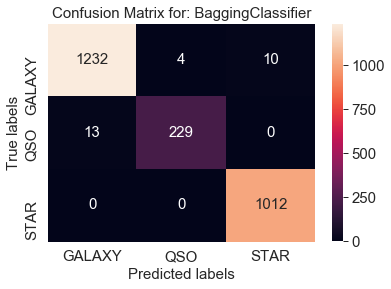

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.67954697 0.93404397 0.68066667 0.82054703 0.74116077]
Accuracy: 0.771 (+/- 0.193)
AdaBoostClassifier :
 [[1223   16    7]
 [ 125  117    0]
 [ 151    0  861]]


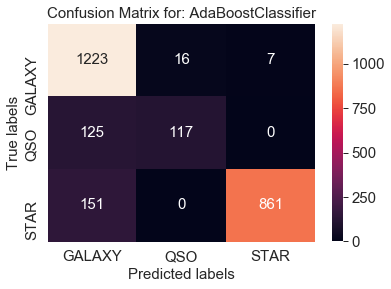

              precision    recall  f1-score   support

      GALAXY       0.82      0.98      0.89      1246
         QSO       0.88      0.48      0.62       242
        STAR       0.99      0.85      0.92      1012

   micro avg       0.88      0.88      0.88      2500
   macro avg       0.90      0.77      0.81      2500
weighted avg       0.89      0.88      0.88      2500



[0.84810127 0.83744171 0.85666667 0.84923282 0.85056704]
Accuracy: 0.848 (+/- 0.012)
SGDClassifier :
 [[998   3 245]
 [ 12 226   4]
 [ 80   0 932]]


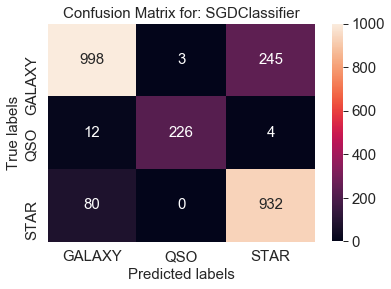

              precision    recall  f1-score   support

      GALAXY       0.92      0.80      0.85      1246
         QSO       0.99      0.93      0.96       242
        STAR       0.79      0.92      0.85      1012

   micro avg       0.86      0.86      0.86      2500
   macro avg       0.90      0.89      0.89      2500
weighted avg       0.87      0.86      0.86      2500



[0.98334444 0.97868088 0.98333333 0.98799199 0.98465644]
Accuracy: 0.984 (+/- 0.006)
MLPClassifier :
 [[1191    3   52]
 [  15  227    0]
 [   0    0 1012]]


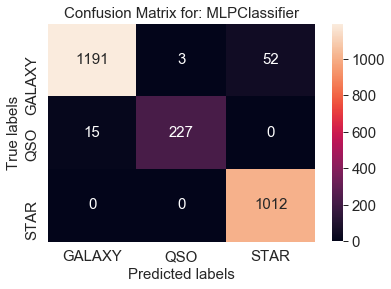

              precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.97      1246
         QSO       0.99      0.94      0.96       242
        STAR       0.95      1.00      0.97      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.98      0.96      0.97      2500
weighted avg       0.97      0.97      0.97      2500



[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]


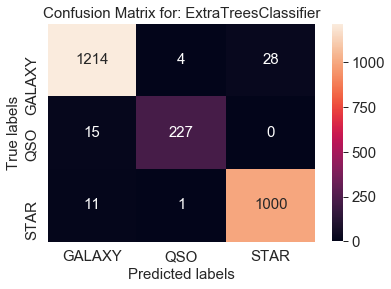

              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.88207861 0.64690207 0.80933333 0.94996664 0.91727819]
Accuracy: 0.841 (+/- 0.216)
PassiveAggressiveClassifier :
 [[896  20 330]
 [ 15 227   0]
 [ 44   0 968]]


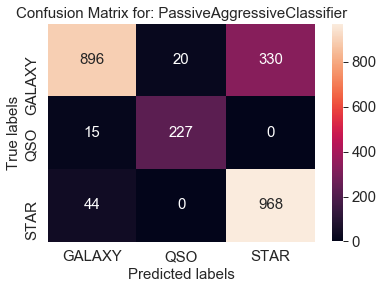

              precision    recall  f1-score   support

      GALAXY       0.94      0.72      0.81      1246
         QSO       0.92      0.94      0.93       242
        STAR       0.75      0.96      0.84      1012

   micro avg       0.84      0.84      0.84      2500
   macro avg       0.87      0.87      0.86      2500
weighted avg       0.86      0.84      0.83      2500



[0.81678881 0.80146569 0.82266667 0.80920614 0.82655103]
Accuracy: 0.815 (+/- 0.018)
RidgeClassifier :
 [[1060    1  185]
 [  12  185   45]
 [ 274    0  738]]


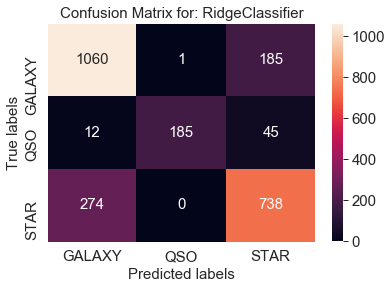

              precision    recall  f1-score   support

      GALAXY       0.79      0.85      0.82      1246
         QSO       0.99      0.76      0.86       242
        STAR       0.76      0.73      0.75      1012

   micro avg       0.79      0.79      0.79      2500
   macro avg       0.85      0.78      0.81      2500
weighted avg       0.80      0.79      0.79      2500



[0.98134577 0.9733511  0.98066667 0.97464977 0.98465644]
Accuracy: 0.979 (+/- 0.009)
GaussianNB :
 [[1218   21    7]
 [  11  231    0]
 [   3    7 1002]]


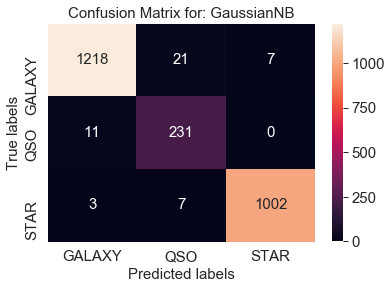

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.89      0.95      0.92       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.96      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



Something bad had happened... Could not proceed for the:  MultinomialNB 

[0.93537642 0.91672219 0.946      0.9299533  0.92328219]
Accuracy: 0.930 (+/- 0.020)
LinearDiscriminantAnalysis :
 [[1131    0  115]
 [  45  185   12]
 [  74    2  936]]


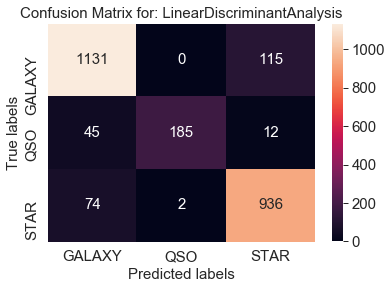

              precision    recall  f1-score   support

      GALAXY       0.90      0.91      0.91      1246
         QSO       0.99      0.76      0.86       242
        STAR       0.88      0.92      0.90      1012

   micro avg       0.90      0.90      0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.90      0.90      0.90      2500



[0.9793471  0.98134577 0.98666667 0.98865911 0.98732488]
Accuracy: 0.985 (+/- 0.007)
QuadraticDiscriminantAnalysis :
 [[1225   15    6]
 [   5  237    0]
 [   9    2 1001]]


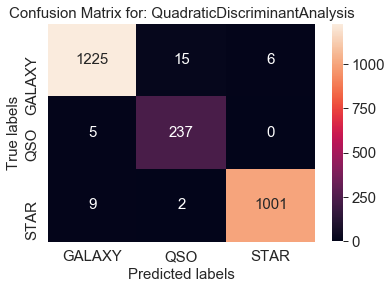

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.93      0.98      0.96       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.97      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



Something bad had happened... Could not proceed for the:  VotingClassifier 

By Acc:
PolyKernelSVM 0.9898679073190699
XGBClassifier 0.9890675515263192
GradientBoostingClassifier 0.9884010622819537
RandomForestClassifier 0.9881342177189115
QuadraticDiscriminantAnalysis 0.9846687054823876
DecisionTreeClassifier 0.9844010612152865
BaggingClassifier 0.9842683498081554
MLPClassifier 0.9836014164154443
ExtraTreesClassifier 0.9809344818375475
RbfKernelSVM 0.9808023931862488
GaussianNB 0.9789339479113842
NuSVC 0.9524046052761209
LinearDiscriminantAnalysis 0.9302668182519191
LinearSVM 0.9232008611559381
KNN 0.880801645

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set_context("paper", rc={"font.size":15,
                          "axes.titlesize":15,
                         "axes.labelsize":15,
                          "xtick.labelsize":15,
                          "ytick.labelsize":15,
#                         "legend.fontsize":27
                            }) 
    results = helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)